The highlights of this notebooks:
* Refresher on attempting application of Pytorch on text dataset using different methods to prep data
* Application of self embedding model as well as LSTM for basic classification and some other basic classifiers
* Application of pre-trained embedding model (GloVe) for classification using LSTM


In [ ]:
%autosave 300
%reload_ext autoreload
%config Completer.use_jedi = False

In [ ]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp"
)
print(os.getcwd())

In [ ]:
import torch
from torchinfo import summary
import torchtext
import os
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import ngrams_iterator
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import re
from torchview import draw_graph
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from src.pytorch_helpers import *
from torch.optim import Adam

plt.rcParams["figure.figsize"] = (25, 20)

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16
epochs = 10
lr = 1e-3

Basic Data Preparation 

In [ ]:
os.makedirs("./data", exist_ok=True)
train_dataset, test_dataset = torchtext.datasets.AG_NEWS(root="./data")
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

In [ ]:
label, text = next(iter(train_dataset))
print(text)
print(label)

In [ ]:
for i, x in zip(range(5), train_dataset):
    print(f"**{target_classes[x[0]]}** -> {x[1]}\n")

In [ ]:
# each list contains a tuple of label and text
train_dataset = list(train_dataset)
test_dataset = list(test_dataset)

The first step is to convert text to tokens — tokenization

In [ ]:
tokenizer = get_tokenizer("basic_english")

In [ ]:
tokenizer(train_dataset[0][-1])

Vectorization using vocabulary

In [ ]:
# counter to measure frequency
Counter(tokenizer(train_dataset[0][-1]))

In [ ]:
unk_token = "<unk>"
default_index = -1

Directly using an orderdict and vocab class

In [ ]:
# counter_token = Counter()
# for label, line in train_dataset:
#     counter_token.update(tokenizer(line))

In [ ]:
# vocabulary = torchtext.vocab.vocab(
#     counter_token, min_freq=1, specials=[unk_token])
# vocabulary.set_default_index(default_index)

In [ ]:
# print(vocabulary["<unk>"])  # prints 0
# print(vocabulary["out of vocab"])  # prints -1

Best way is using an iterator and using build_vocab_from_iterator

In [ ]:
def build_vocab_iter(datasets):
    """yields tokenized text"""
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)


vocabulary = build_vocab_from_iterator(
    build_vocab_iter([train_dataset, test_dataset]), specials=[unk_token]
)  # build vocab from an iterator
# anything unk will be have a default index
vocabulary.set_default_index(default_index)

In [ ]:
print(vocabulary["<unk>"])  # prints 0
print(vocabulary["out of vocab"])  # prints -1

In [ ]:
# This vocabulary maps words to indices present in the num corpus

print([(vocabulary[token], token) for token in tokenizer(train_dataset[-1][-1])])

In [ ]:
vocab_size = len(vocabulary)
print(f"Vocab size if {vocab_size}")

In [ ]:
vocabulary(["Maya"])

In [ ]:
# Create and encoder and decoder function for word to index and reverse
def encoder(x):
    """from string to integers"""
    return vocabulary(tokenizer(x))


def decoder(x):
    """from integers to string"""
    return [vocabulary.get_itos()[index] for index in x]

In [ ]:
vec = encoder(train_dataset[0][-1])

In [ ]:
" ".join(decoder(vec))

Tokenization misses out on BiGrams, TriGrams and N-Grams

In [ ]:
# first tokenize 1v1 and then 2 adjacent words together
list(ngrams_iterator(tokenizer(train_dataset[0][-1]), 2))

In [ ]:
bi_counter_token = Counter()
for label, line in train_dataset:
    bi_counter_token.update(ngrams_iterator(tokenizer(line), 2))

bi_vocabulary = torchtext.vocab.vocab(
    bi_counter_token, min_freq=2, specials=[unk_token]
)
bi_vocabulary.set_default_index(default_index)

In [ ]:
bi_vocab_size = len(bi_vocabulary)
print(f"Vocab size if {bi_vocab_size}")

As ngrams leads to more words we will stick to unigrams

we’ll explore some of the approaches to feeding variable-length text into a neural network to collapse the input sequence into a fixed-length vector, which can then be used in the classifier.

BoW vector: Traditional representation where words are indexed, and vector elements count word occurrences in a document or sum one-hot-encoded vectors.

In [ ]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords') 

In [ ]:
# Create a set of stop words
stop_words = set(stopwords.words("english"))


# Define a function to remove stop words from a sentence
def remove_stop_words(sentence):
    # Split the sentence into individual words
    words = sentence.split(" ")

    # Use a list comprehension to remove stop words
    filtered_words = [word for word in words if word not in stop_words]

    # Join the filtered words back into a sentence
    return " ".join(filtered_words)

In [ ]:
def to_bow(text, vocab_size):
    result_vector = torch.zeros(vocab_size, dtype=torch.float32)
    text = remove_stop_words(text)
    for i in encoder(text):
        if i < vocab_size:
            result_vector[i] += 1
    return result_vector

In [ ]:
bow_vector = to_bow(train_dataset[0][-1], vocab_size)

In [ ]:
len(bow_vector)  # sparse vector

BOW classifier

In [ ]:
def vectorize_batch(batch):
    """Vectorize the batch"""
    return (
        torch.stack([to_bow(t[1], vocab_size) for t in batch])
        .type(torch.float32)
        .to(device),
        torch.tensor([t[0] - 1 for t in batch], dtype=torch.int64).to(device),
    )

In [ ]:
# As bow is very slow we will do it only for 1000 entries
sub_train_dataset = train_dataset[: batch_size * 100]
sub_test_dataset = test_dataset[: batch_size * 100]

In [ ]:
train_loader = DataLoader(
    sub_train_dataset, batch_size=batch_size, collate_fn=vectorize_batch
)
test_loader = DataLoader(
    sub_test_dataset, batch_size=batch_size, collate_fn=vectorize_batch
)

In [ ]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
class BasicBOWClassifier(nn.Module):
    """Basic Bow Classifier"""

    def __init__(self, num_classes):
        super(BasicBOWClassifier, self).__init__()

        self.fn_layer = nn.Sequential(
            nn.Linear(vocab_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.fn_layer(x)

In [ ]:
basic_classifier = BasicBOWClassifier(4).to(device)
print(basic_classifier)
summary(basic_classifier, input_size=[(batch_size, vocab_size)],)

In [ ]:
# graphical representation of the model architecture
model_graph = draw_graph(
    basic_classifier, input_size=(1, batch_size, vocab_size), expand_nested=True
)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [ ]:
# driver setup
optimizer = optim.Adam(basic_classifier.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device=device, num_classes=4)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        basic_classifier,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        basic_classifier,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

In [ ]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels="BOWModel",
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

In [ ]:
Y_actual, Y_preds = MakePredictions(basic_classifier, test_loader)
print(Y_actual.shape)
print(Y_preds.shape)

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Application of Embedding Models

- limiting len and addition of padding 
- tokenize and vectorize
- Custom Embedding Model

In [ ]:
def vectorize_batch(batch, max_size=50):
    """Vectorize the batch"""
    Y, X = list(zip(*batch))
    # vectorization ie text to int
    X = X = [encoder(x) for x in X]
    # padding of sequences till max len
    X = (
        torch.stack(
            [
                (
                    (
                        torch.nn.functional.pad(
                            torch.tensor(t), (0, max_size - len(t)), "constant", 0
                        )
                    )
                    if len(t) < max_size
                    else torch.tensor(t[:max_size])
                )
                for t in X
            ]
        )
        .type(torch.int32)
        .to(device)
    )
    Y = [y - 1 for y in Y] if min(y) == 1 else Y 
    
    return X, torch.tensor(Y, dtype=torch.int64).to(device)

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=vectorize_batch
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, collate_fn=vectorize_batch
)

In [ ]:
for idx, (X, Y) in enumerate(train_loader):
    print(X.shape, Y.shape)
    if idx == 3:
        break

In [ ]:
class EmbeddingClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_size=50):
        super(EmbeddingClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten()
        self.fc_layer = nn.Linear(embedding_dim * max_size, num_classes)

    def forward(self, x):
        x = self.embedding_layer(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        x = self.fc_layer(x)
        return x

In [ ]:
embedding_classifier = EmbeddingClassifier(vocab_size, 50, 4).to(device)
print(embedding_classifier)
# summary(
#     embedding_classifier,
#     input_size=X.shape,
#     device=device,
# )

In [ ]:
# driver setup
optimizer = optim.Adam(embedding_classifier.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device=device, num_classes=4)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        embedding_classifier,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        embedding_classifier,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

In [ ]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["EmbeddingModel"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

In [ ]:
Y_actual, Y_preds = MakePredictions(embedding_classifier, test_loader)
print(Y_actual.shape)
print(Y_preds.shape)

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Embedding Bag Layer - Handle different sizes of input sequences without padding

https://visualstudiomagazine.com/Articles/2021/07/06/~/media/ECG/visualstudiomagazine/Images/2021/07/sentiment2.ashx
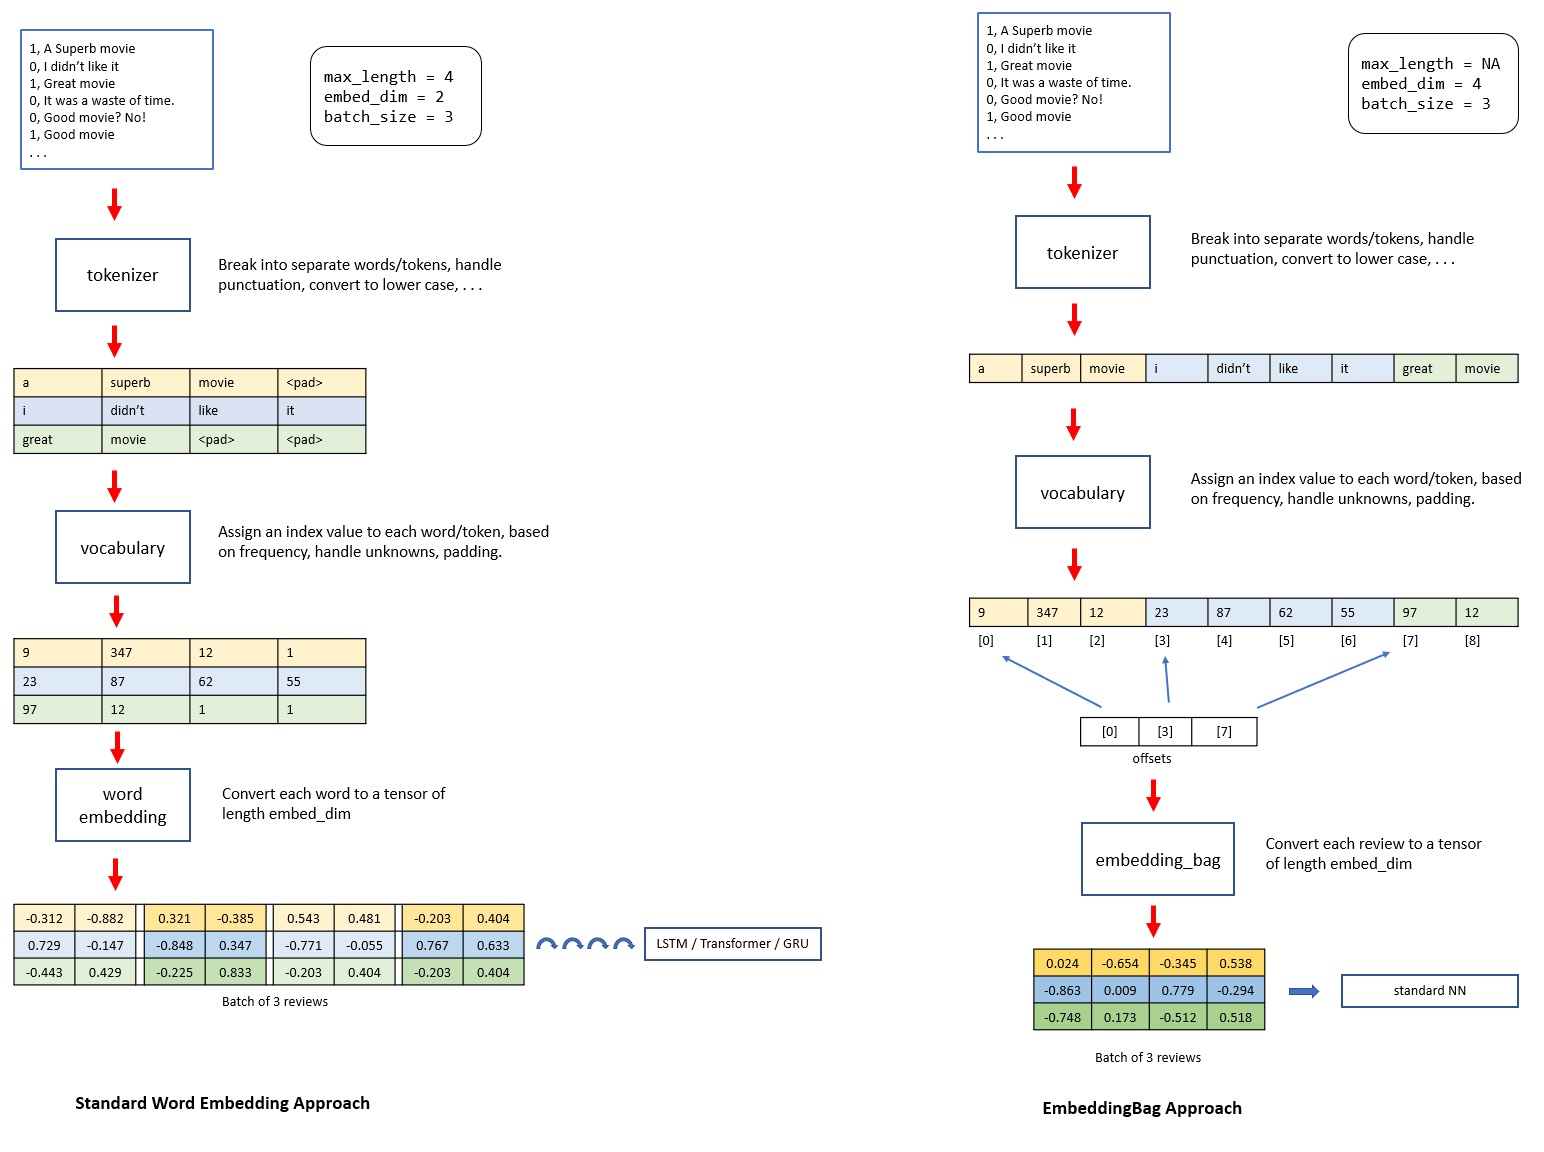

In [ ]:
def collate_data(batch):
    # needs a global vocab and tokenizer
    label_lst, review_lst, offset_lst = [], [], [0]
    for _lbl, _rvw in batch:
        label_lst.append(int(_lbl) - 1 if int(_lbl) != 0 else 0)

        rvw_idxs = encoder(_rvw)  # string to list of ints
        rvw_idxs = torch.tensor(rvw_idxs, dtype=torch.int64)  # to tensor
        review_lst.append(rvw_idxs)
        offset_lst.append(len(rvw_idxs))

    label_lst = torch.tensor(label_lst, dtype=torch.int64).to(device)
    offset_lst = torch.tensor(offset_lst[:-1]).cumsum(dim=0).to(device)
    review_lst = torch.cat(review_lst).to(device)  # 2 tensors to 1

    return (review_lst, label_lst, offset_lst)

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_data, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, collate_fn=collate_data,
)

In [ ]:
for idx, (X, Y, off) in enumerate(train_loader):
    print(X.shape, Y.shape, len(off))
    if idx == 3:
        break

In [ ]:
class EmbedBagClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = torch.nn.EmbeddingBag(vocab_size, embed_dim)
        self.fc = torch.nn.Linear(embed_dim, num_class)

    def forward(self, text, off):
        x = self.embedding(text, off)
        return self.fc(x)

In [ ]:
embedding_classifier_bag = EmbedBagClassifier(vocab_size, 50, 4).to(device)
print(embedding_classifier_bag)
# summary(
#     embedding_classifier,
#     input_size=X.shape,
#     device=device,
# )

In [ ]:
# driver setup
optimizer = optim.Adam(embedding_classifier_bag.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device=device, num_classes=4)

In [ ]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module_bag(
        embedding_classifier_bag,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module_bag(
        embedding_classifier_bag,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

In [ ]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["EmbeddingModel"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

RNN PAD SEQUENCES

For classification via LSTM we are using a easy dataset without much preprocessing

pack_padded_sequence is a function in PyTorch used to handle variable-length sequences efficiently, especially when working with recurrent neural networks (RNNs). It is commonly used in combination with RNNs, GRUs, or LSTMs when your input sequences have different lengths. This function helps by packing the sequences into a format that the RNN can process more efficiently.

Here's a detailed explanation and an example of how to use pack_padded_sequence.

Key Points:
Variable-Length Sequences:
In natural language processing (NLP) and other sequence-based tasks, sequences can have varying lengths. For instance, sentences in a batch might not all be of the same length.

Padding Sequences:
Before feeding them to an RNN, sequences are typically padded to ensure they have the same length. This is necessary for batch processing but can be inefficient as the RNN has to process the padded elements.

Packing Sequences:
pack_padded_sequence allows you to convert a padded batch of sequences into a packed sequence object, which the RNN can process more efficiently by ignoring the padded elements.

Usage:
To use pack_padded_sequence, follow these steps:

Prepare Your Data:

Ensure your sequences are padded.
Create a tensor containing the lengths of each sequence before padding.
Sort by Length:

Sort the sequences and their lengths in descending order by sequence length. This is required because pack_padded_sequence expects the sequences to be sorted by length.
Use pack_padded_sequence:

Pack the padded sequence using pack_padded_sequence before feeding it to the RNN.

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Example data
sequences = [
    torch.tensor([1, 2, 3, 4]),      # Length 4
    torch.tensor([5, 6, 7]),         # Length 3
    torch.tensor([8, 9]),            # Length 2
    torch.tensor([10])               # Length 1
]

# Pad the sequences to the same length
padded_sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True)

# Lengths of the original sequences
lengths = torch.tensor([4, 3, 2, 1])

# Sort the sequences by length in descending order
lengths, perm_idx = lengths.sort(0, descending=True)
padded_sequences = padded_sequences[perm_idx]

# Define an LSTM
lstm = nn.LSTM(input_size=1, hidden_size=2, batch_first=True)

# Pack the padded sequence
packed_input = pack_padded_sequence(padded_sequences.unsqueeze(-1).float(), lengths, batch_first=True)

# Pass the packed sequence to the LSTM
packed_output, (h_n, c_n) = lstm(packed_input)

# If needed, unpack the packed sequence
output, _ = pad_packed_sequence(packed_output, batch_first=True)

print("Padded Sequences:\n", padded_sequences)
print("\nPacked Input:\n", packed_input)
print("\nLSTM Output:\n", output)


pad_packed_sequence is a function in PyTorch that does the inverse operation of pack_padded_sequence. It converts a packed sequence back into a padded sequence, which can be useful if you need to process or analyze the output from an RNN. Here's how you can use pad_packed_sequence in conjunction with pack_padded_sequence.

Steps to Use pad_packed_sequence
Prepare Data: Create your sequences and pad them.
Pack the Padded Sequence: Use pack_padded_sequence to handle variable-length sequences.
Process with RNN: Feed the packed sequence to an RNN (e.g., LSTM, GRU).
Unpack the Sequence: Use pad_packed_sequence to convert the output back to a padded sequence.

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Example sequences
sequences = [
    torch.tensor([1, 2, 3, 4]),      # Length 4
    torch.tensor([5, 6, 7]),         # Length 3
    torch.tensor([8, 9]),            # Length 2
    torch.tensor([10])               # Length 1
]

# Pad the sequences to the same length
padded_sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True)

# Lengths of the original sequences
lengths = torch.tensor([4, 3, 2, 1])

# Sort the sequences by length in descending order
lengths, perm_idx = lengths.sort(0, descending=True)
padded_sequences = padded_sequences[perm_idx]

# Pack the padded sequence
packed_input = pack_padded_sequence(padded_sequences.unsqueeze(-1).float(), lengths, batch_first=True, enforce_sorted=True)

# Define an LSTM
lstm = nn.LSTM(input_size=1, hidden_size=2, batch_first=True)

# Pass the packed sequence to the LSTM
packed_output, (h_n, c_n) = lstm(packed_input)

# Unpack the sequence
output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)

print("Padded Sequences:\n", padded_sequences)
print("\nPacked Input:\n", packed_input)
print("\nLSTM Output:\n", output)
print("\nOutput Lengths:\n", output_lengths)
